![Image](https://camo.githubusercontent.com/08b243a6361d39fa7cc87ab377f5a8e3d942f9141b803a70b0f1bc0bc9158822/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f3538333732372f32636362366331362d373933372d316432662d663466312d3631383762383038386262612e706e67)

In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
import matplotlib.pyplot as plt

In [4]:
class Mnisttox(Dataset):
    def __init__(self, datasets, labels: list):
        self.dataset = [datasets[i][0] for i in range(len(datasets)) if datasets[i][1] in labels]
        self.labels = labels
        self.len_oneclass = int(len(self.dataset) / 10)

    def __len__(self):
        return int(len(self.dataset))

    def __getitem__(self, idx):
        img = self.dataset[idx]

        return img, []

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)

        return xhat

In [6]:
z_dim = 64
batch_size = 16
num_epochs = 10
learning_rate = 3.0e-4
n = 6
cuda = True

In [7]:
model = AutoEncoder(z_dim)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [8]:
if cuda:
    model.cuda()

In [10]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, transform=img_transform, download=True)
train_1 = Mnisttox(train_dataset, [1])
train_loader = DataLoader(train_1, batch_size=batch_size, shuffle=True)

losses = np.zeros(num_epochs)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 102kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 325kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.65MB/s]


In [13]:
import pylab

In [14]:
for epoch in range(num_epochs):
    i = 0

    for img, _ in train_loader:
        x = img.view(img.size(0), -1)

        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)

        xhat = model(x)

        loss = mse_loss(xhat, x)
        losses[epoch] = losses[epoch] * (i / (i + 1.)) + loss * (1. / (i + 1.))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1

    plt.figure()
    pylab.xlim(0, num_epochs)
    plt.plot(range(0, num_epochs), losses, label="loss")
    plt.legend()
    plt.close()

    print("epoch [{}/{}], loss: {:.4f}".format(epoch + 1, num_epochs, loss))

epoch [1/10], loss: 0.0072
epoch [2/10], loss: 0.0070
epoch [3/10], loss: 0.0117
epoch [4/10], loss: 0.0080
epoch [5/10], loss: 0.0207
epoch [6/10], loss: 0.0112
epoch [7/10], loss: 0.0222
epoch [8/10], loss: 0.0095
epoch [9/10], loss: 0.0178
epoch [10/10], loss: 0.0117


In [15]:
test_dataset = MNIST("./data", train=False, download=True, transform=img_transform)
test_1_9 = Mnisttox(test_dataset, [1, 9])
test_loader = DataLoader(test_1_9, batch_size=len(test_dataset), shuffle=False)

In [16]:
for img, _ in test_loader:
    x = img.view(img.size(0), -1)

    if cuda:
        x = Variable(x).cuda()
    else:
        x = Variable(x)

    xhat = model(x)
    x = x.cpu().detach().numpy()
    xhat = xhat.cpu().detach().numpy()
    x = x / 2 + 0.5
    xhat = xhat / 2 + 0.5

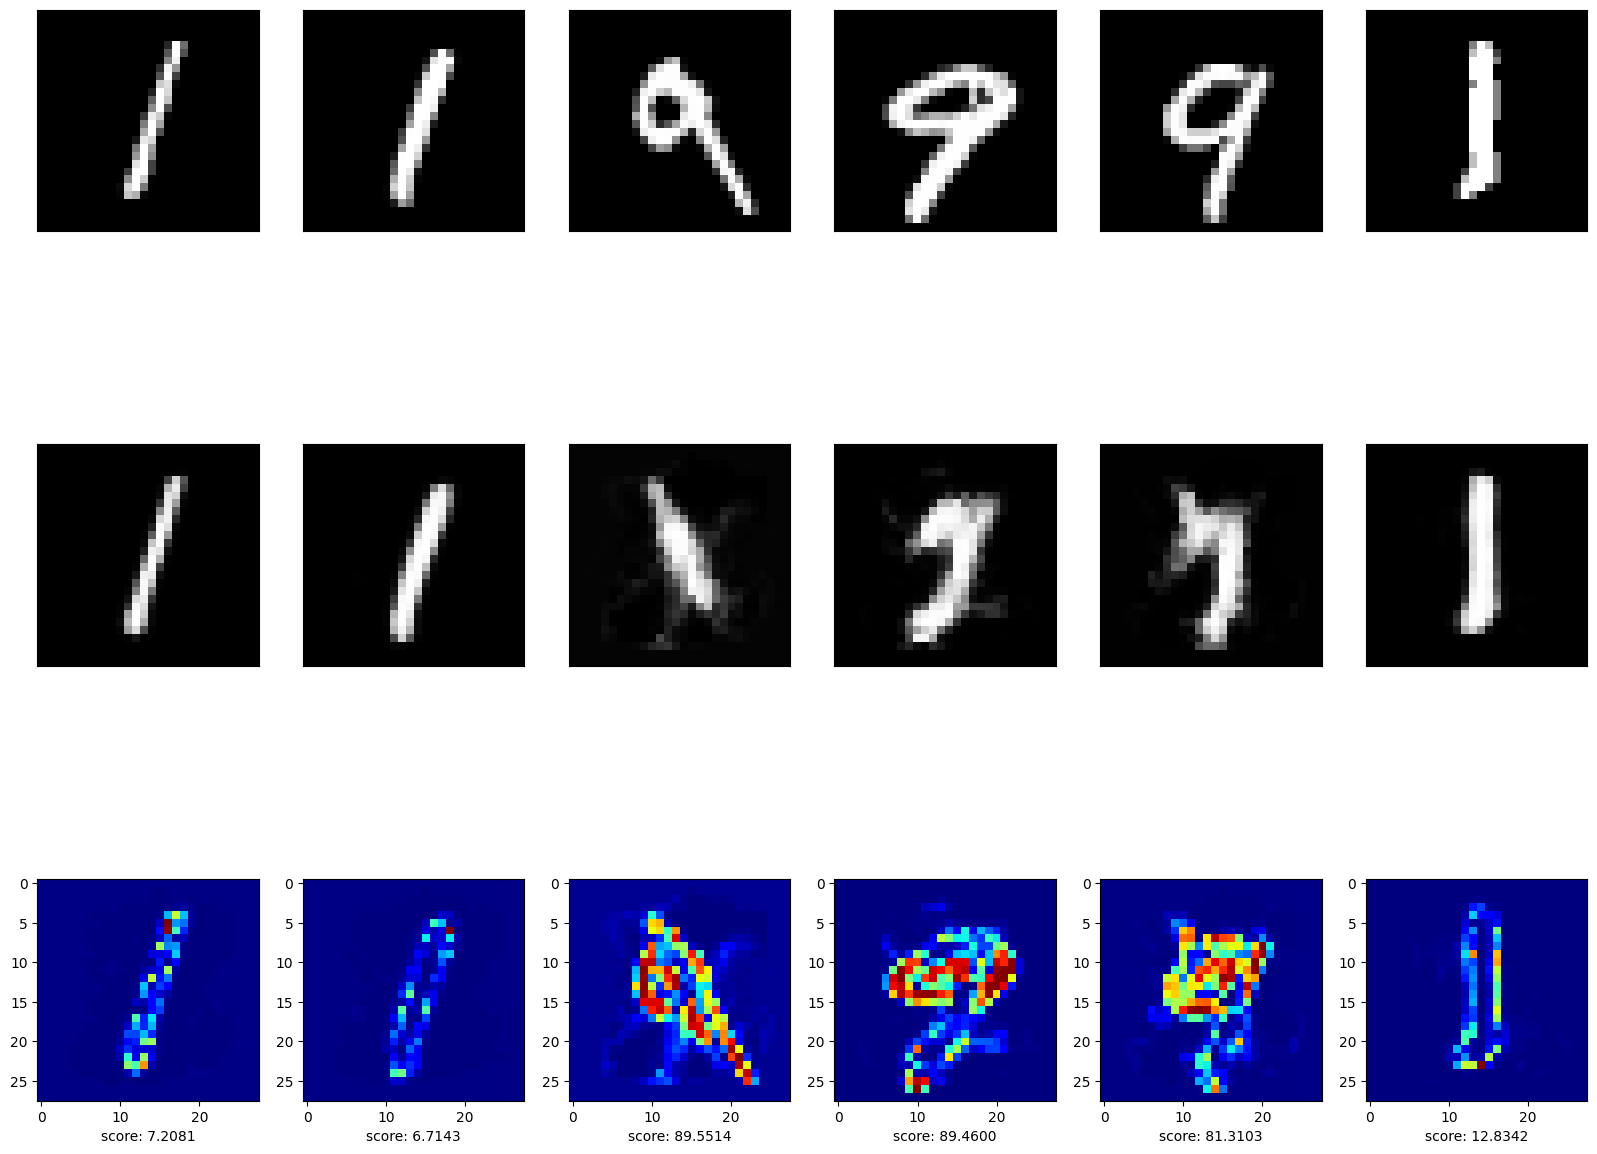

In [17]:
plt.figure(figsize=(20, 16))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(xhat[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    diff_img = np.abs(x[i] - xhat[i])

    diff = np.sum(diff_img)

    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(diff_img.reshape(28, 28), cmap="jet")

    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_xlabel("score: {:.4f}".format(diff))

plt.show()